In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility imports
from utilities.processing_utility import get_q_2_cw_data 
from utilities.processing_utility import get_train_test_split, get_moving_average

from utilities.plotting_utility import plot_price_and_returns, plot_strategy_positions, plot_pnl

from utilities.strategy_utilities import *

from utilities.performance_utilities import sharpe_ratio, sortino_ratio, max_drawdown, calmar_ratio

# strategy imports

from strategies.gp_mean_reversion import optimise_marginal_likelihood, get_gp_mean_reversion_signal, get_constant_gp, get_gp_posterior


In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


In [3]:
# get train test split
split_idx = int(len(df) * 0.7)
risk_free_rate_series = torch.tensor(df['daily_effr'].to_numpy(), dtype=torch.float32)
excess_return_data = torch.tensor(df['daily_excess_returns'].to_numpy(), dtype=torch.float32)
norm_excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_data, test_data = get_train_test_split(splitindex = split_idx, RFR = risk_free_rate_series, daily_R = excess_return_data, norm_R = norm_excess_return_data, P = price_data, X = x_data)

rfr_train, rfr_test = train_data['RFR'], test_data['RFR'] #  risk free rate
daily_r_train, daily_r_test = train_data['daily_R'], test_data['daily_R'] # daily excess returns
norm_r_train, norm_r_test = train_data['norm_R'], test_data['norm_R'] # normalised daily excess returns
p_train, p_test = train_data['P'], test_data['P'] # adjusted closing price
x_train, x_test = train_data['X'], test_data['X'] # x data

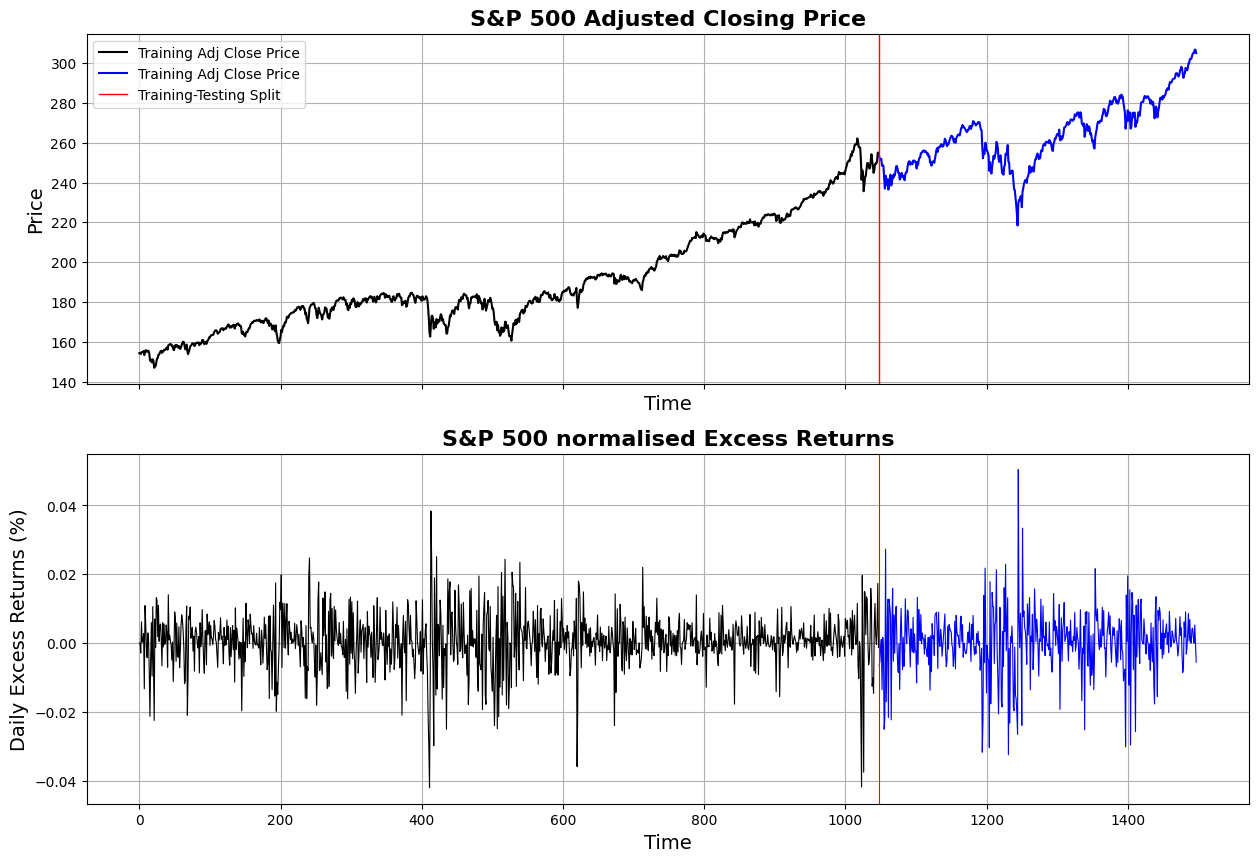

In [4]:
fig = plot_price_and_returns(x_train, p_train, daily_r_train, x_test, p_test, daily_r_test)

# Method 1: Using the _evidence_

In [5]:
lengthscale_hat, noise_hat = optimise_marginal_likelihood(
                                inputs=x_train,
                                targets=norm_r_train,
                                n_iter = 100)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
           10           |   1.4003283977508545   |        0.64912         |        0.64939         
----------------------------------------------------------------------------------------------------
           20           |   1.3927620649337769   |        0.60243         |        0.60434         
----------------------------------------------------------------------------------------------------
           30           |   1.382900595664978    |        0.55907         |        0.56377         
----------------------------------------------------------------------------------------------------
           40           |   1.3756746053695679   |        0.52034         |        0.52922         
----------------------------------------------------------------------------------------------------
           50           |   1.3723843097686768   |        0.48742         |        0.50049      

In [6]:
# get signal
train_signal, train_buy_mask, train_sell_mask = get_gp_mean_reversion_signal(x_train, norm_r_train, lengthscale_hat, noise_hat)
test_signal, test_buy_mask, test_sell_mask = get_gp_mean_reversion_signal(x_test, norm_r_test, lengthscale_hat, noise_hat)

# Visualise Strategies

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_17032/527102777.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_train, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')


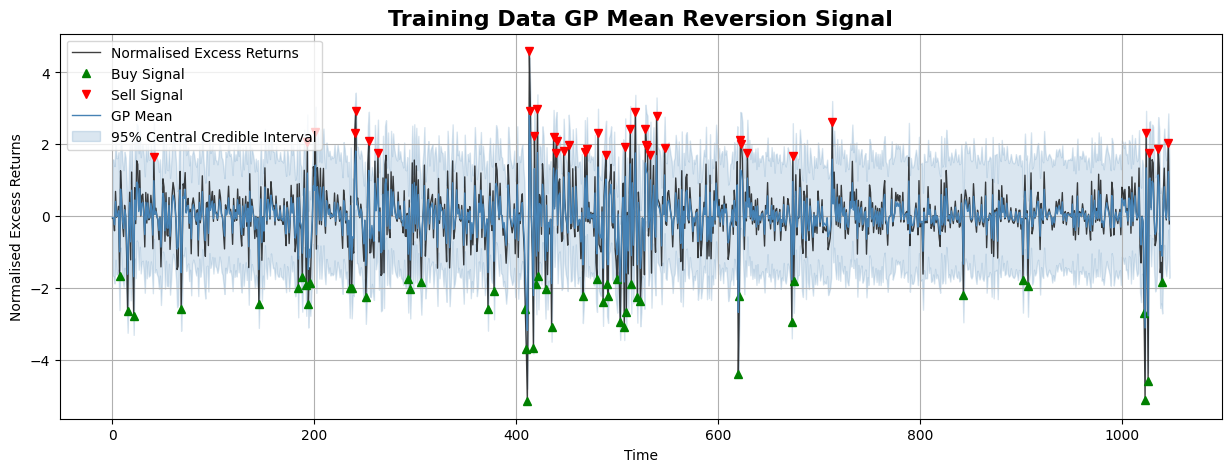

In [7]:
# Train strategy
constant_gp = get_constant_gp(x_train=x_train, y_train=norm_r_train, length_scale=lengthscale_hat, noise=noise_hat)
f_preds = get_gp_posterior(constant_gp, x_train)
lower, upper = f_preds.confidence_region()

# plot training data
plt.plot(x_train, norm_r_train, 'black', lw = 1, alpha = .75, label = 'Normalised Excess Returns')

# plot signals
plt.plot(x_train[train_buy_mask == 1.], norm_r_train[train_buy_mask == 1], 'g^', label = 'Buy Signal')
plt.plot(x_train[train_sell_mask == 1], norm_r_train[train_sell_mask == 1], 'rv', label = 'Sell Signal')

# plot GP
plt.plot(x_train, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')
plt.fill_between(x_train, lower.detach().numpy(), upper.detach().numpy(),color = 'steelblue', alpha=0.2, label = '95% Central Credible Interval')

plt.title('Training Data GP Mean Reversion Signal', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Normalised Excess Returns')
plt.grid(True)
plt.legend()

/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_17032/1643282947.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_test, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')


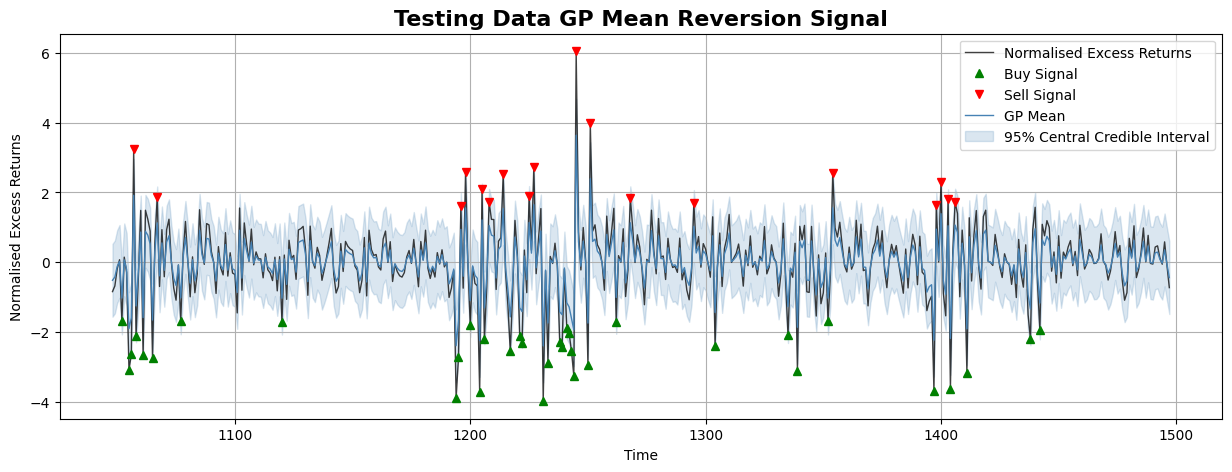

In [8]:
# Train strategy
constant_gp = get_constant_gp(x_train=x_test, y_train=norm_r_test, length_scale=lengthscale_hat, noise=noise_hat)
f_preds = get_gp_posterior(constant_gp, x_test)
lower, upper = f_preds.confidence_region()

# plot training data
plt.plot(x_test, norm_r_test, 'black', lw = 1, alpha = .75, label = 'Normalised Excess Returns')

# plot signals
plt.plot(x_test[test_buy_mask == 1.], norm_r_test[test_buy_mask == 1], 'g^', label = 'Buy Signal')
plt.plot(x_test[test_sell_mask == 1], norm_r_test[test_sell_mask == 1], 'rv', label = 'Sell Signal')

# plot GP
plt.plot(x_test, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')
plt.fill_between(x_test, lower.detach().numpy(), upper.detach().numpy(),color = 'steelblue', alpha=0.2, label = '95% Central Credible Interval')

plt.title('Testing Data GP Mean Reversion Signal', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Normalised Excess Returns')
plt.grid(True)
plt.legend()

In [9]:
# get dollar values and holdings
train_strategy_data = get_theta_and_V(daily_r_train, rfr_train , train_signal, initial_cash = 200_000., leverage = 5.)
test_strategy_data = get_theta_and_V(daily_r_test, rfr_test , test_signal, initial_cash = 200_000., leverage = 5.)

In [10]:
# unpack training data
train_theta = train_strategy_data['theta']
train_V_t = train_strategy_data['V_t']
train_delta_V_t = train_strategy_data['delta_V_t']
train_V_cap = train_strategy_data['V_cap']
train_delta_V_cap = train_strategy_data['delta_V_cap']
train_V_total = train_strategy_data['V_total']
train_delta_V_total = train_strategy_data['delta_V_total']

# unpack test data
test_theta = test_strategy_data['theta']
test_V_t = test_strategy_data['V_t']
test_delta_V_t = test_strategy_data['delta_V_t']
test_V_cap = test_strategy_data['V_cap']
test_delta_V_cap = test_strategy_data['delta_V_cap']
test_V_total = test_strategy_data['V_total']
test_delta_V_total = test_strategy_data['delta_V_total']

**(b). Plot the position of the strategies θt together with the upper and lower bounds $[−V_t \cdot L, V_t \cdot L]$.**


**Calculate the turnover in dollar value traded over time**

$$ \text{TurnoverDollars} = \sum_{t=0}^T |\Delta \theta_t| $$

**Additionally calculate the turnover in number of units traded over time**

$$ \text{TurnoverUnits} = \sum_{t=0}^T | \frac{\theta_{t+1}}{p_{t+1}} - \frac{\theta_t}{p_t} | $$

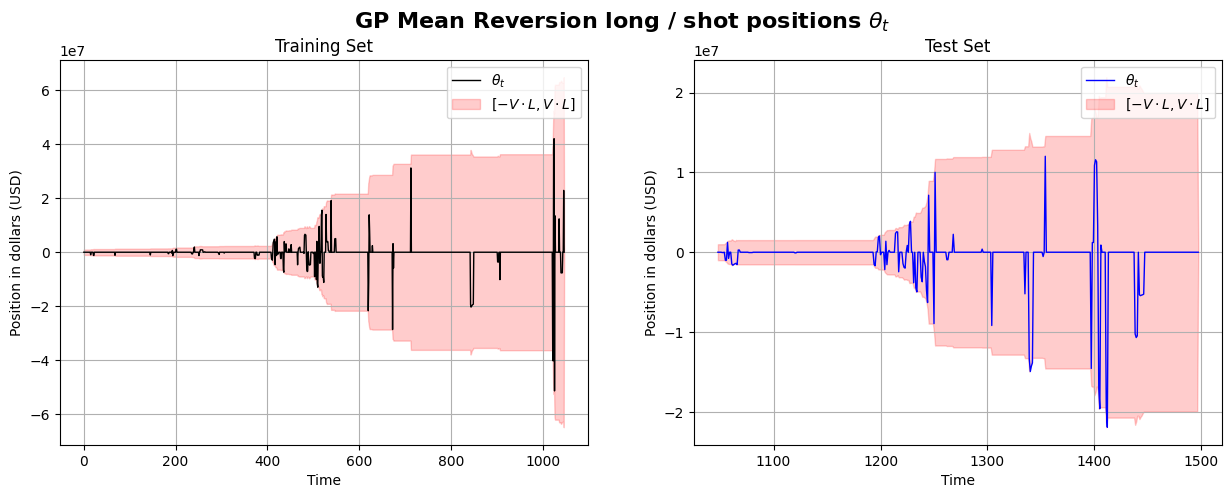

In [11]:
position_fig = plot_strategy_positions(
                    strategy_name = 'GP Mean Reversion',
                    x_train = x_train,
                    train_theta = train_theta,
                    train_V_asset = train_V_t,
                    x_test = x_test,
                    test_theta = test_theta,
                    test_V_asset = test_V_t,)

In [12]:
print('Train Turnover Dollars: ', get_turnover_dollars(train_theta))
print('Train Turnover Units: ', get_turnover_units(train_theta, p_train))
print()
print('Test Turnover Dollars: ', get_turnover_dollars(test_theta))
print('Test Turnover Units: ', get_turnover_units(test_theta, p_test))

Train Turnover Dollars:  65223569.583984375
Train Turnover Units:  372799.17946084926

Test Turnover Dollars:  37755399.28515625
Test Turnover Units:  151664.40926348517


**(c) Create a total PnL series for the strategies, where we assume that unused capital will be put in a money-market and grow at the same risk-free rate, i.e., the value of your account changes by the trading $PnL$, $(\Delta V)$ and the change in the growth of the money-market capital account $(\Delta V^{\text{cap}})$.**

$$ V_{t+1}^\text{total} -  V_{t}^\text{total} = \Delta V_t^\text{total}$$ 

$$ = \Delta V_t + \Delta V_t^\text{cap} $$

$$ = \left( \frac{\Delta p_t}{p_t} - r_t^f \right) \theta_t + \left( V_t^\text{total} - M_t \right)r_t^f $$

**where $M_t = \frac{|\theta_t|}{L}$ is the total margin used and $V_0$ was as above. Plot $\Delta V_t$ , $\Delta V_t^\text{cap}$, and $\Delta V_t^\text{total}$ and plot their accumulated values (i.e., cumsum() of each).**

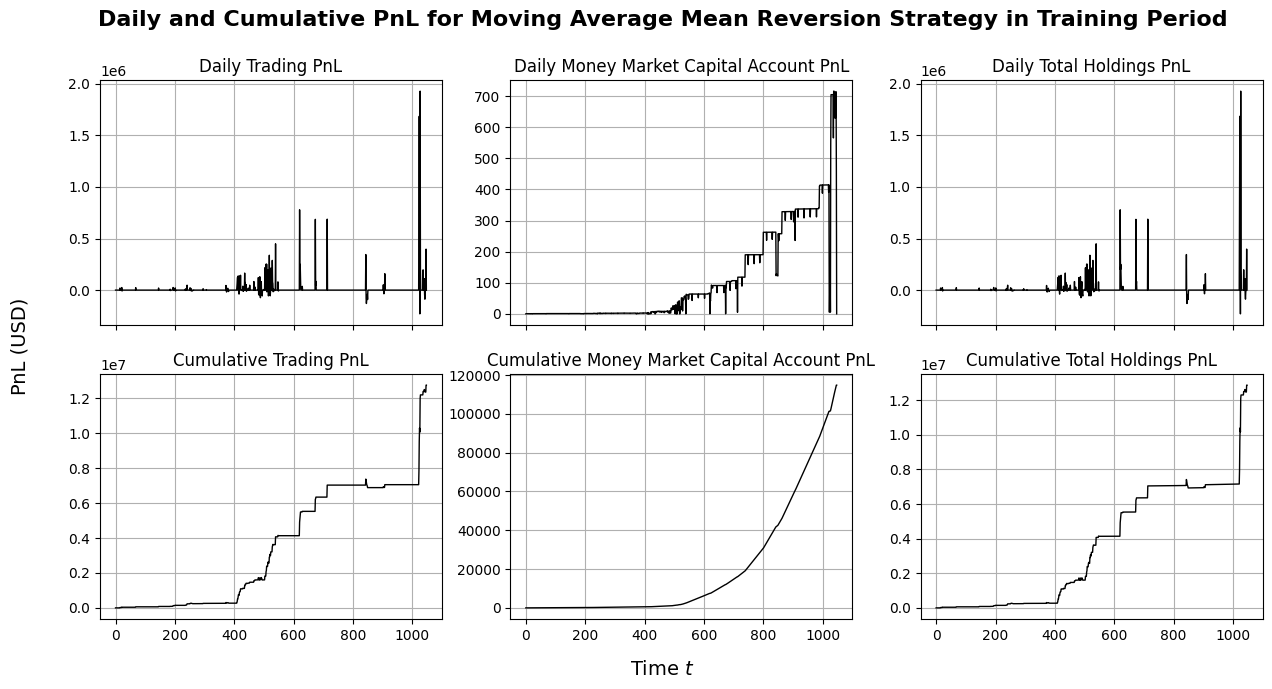

In [12]:
train_pnl_fig = plot_pnl(
    strategy_name = 'Moving Average Mean Reversion',    
    training_set=True,
    x = x_train,
    delta_V_asset = train_delta_V_t,
    delta_V_cap = train_delta_V_cap,
    delta_V_total = train_delta_V_total,)

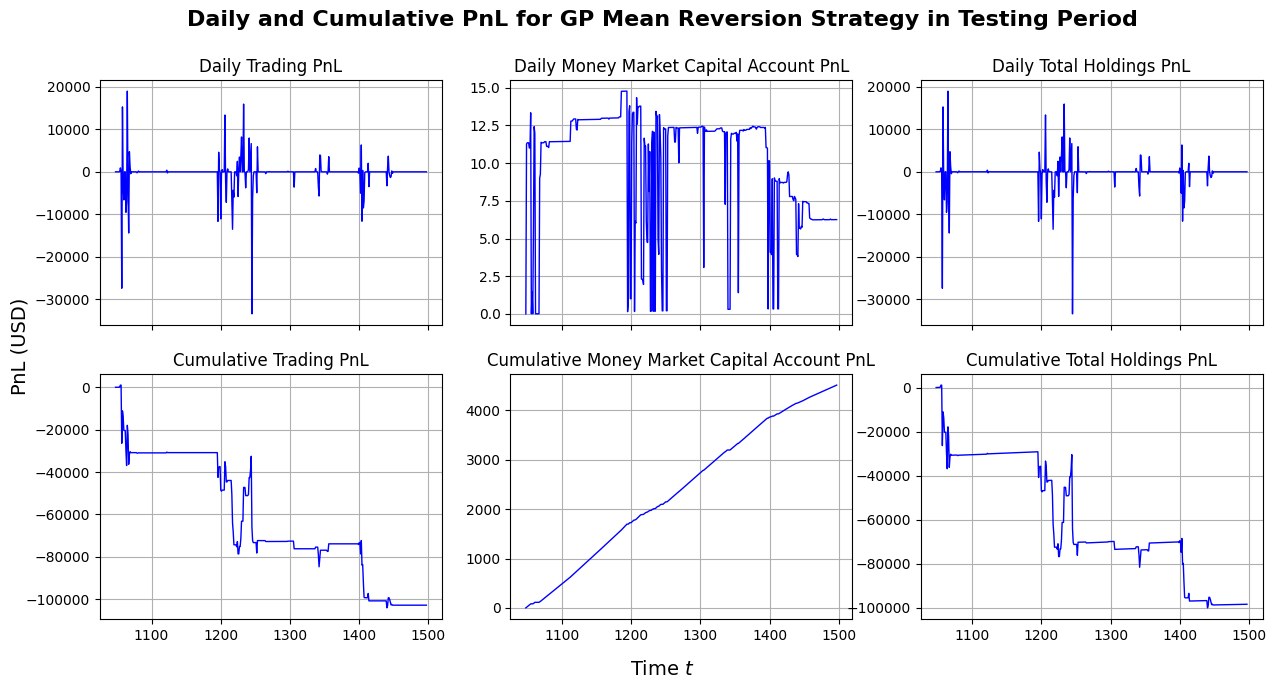

In [14]:
train_pnl_fig = plot_pnl(
    strategy_name = 'GP Mean Reversion',    
    training_set=False,
    x = x_test,
    delta_V_asset = test_delta_V_t,
    delta_V_cap = test_delta_V_cap,
    delta_V_total = test_delta_V_total,)

# Performance Indicators

**(a) Define the excess return of a trading strategy as the daily trading $PnL$, $PnL_t = \Delta V_t$. Use this quantity to compute the Sharpe Ratio (SR), Sortino Ratio, Maximum Drawdown and the Calmar ratio of your strategies. For each of them provide two independent measurements: one within the training set and one within the test set.**

**SHARPE RATIO**

In [15]:
print('Train Sharpe Ratio: ', sharpe_ratio(train_delta_V_t))
print('Test Sharpe Ratio: ', sharpe_ratio(test_delta_V_t))

Train Sharpe Ratio:  -0.6768922799647598
Test Sharpe Ratio:  -1.4877265203556305


**SORTINO RATIO**

In [16]:
print('Train Sortino Ratio: ', sortino_ratio(train_delta_V_t))
print('Test Sortino Ratio: ', sortino_ratio(test_delta_V_t))

Train Sortino Ratio:  -0.2758359648440858
Test Sortino Ratio:  -0.7380641215108512


**MAX DRAWDOWNS**

In [17]:
print('Train Max Drawdown: ', max_drawdown(train_delta_V_t, train_V_t))
print('Test Max Drawdown: ', max_drawdown(test_delta_V_t, test_V_t))

Train Max Drawdown:  -0.5173509790690779
Test Max Drawdown:  -0.6188583815645818


**CALMAR RATIO**

In [18]:
print('Train Calmar Ratio: ', calmar_ratio(train_delta_V_t, train_V_t))
print('Test Calmar Ratio: ', calmar_ratio(test_delta_V_t, test_V_t))

Train Calmar Ratio:  -0.9995343017724342
Test Calmar Ratio:  -1.3377533993952555
